In [82]:
import json
import random
import networkx as nx


with open("./data/zones.json") as f:
    zones_data = json.load(f)

with open("./data/crops.json") as f:
    crops_data = json.load(f)

with open("./data/climate_profiles.json") as f:
    climate_data = json.load(f)

with open("./data/soil_moisture_profiles.json") as f:
    soil_moisture = json.load(f)



In [83]:
class Zone:
    def __init__(self, zone_id, data, climate_profile, soil_moisture):

        self.id = zone_id
        self.name = data["name"]
        self.soil_types = data["soil_types"]
        self.dominant_soil = data["dominant_soil"]
        self.viable_crops = data["viable_crops"]
        self.agriculture_type = data["agriculture_type"]

        self.climate_profile = climate_profile

        # Soil moisture correctly extracted here
        sm_data = soil_moisture["zones"][zone_id]
        self.mean_sm = sm_data["mean"]
        self.std_sm = sm_data["std"]

        self.shared_crop_yield = {}
        self.shared_crop_profit = {}


    

In [84]:
from mesa import Agent
from mesa import Model
from mesa.agent import AgentSet

class FarmerAgent(Agent):
           
    def __init__(self, model, unique_id, zone, land_size, strategy_type):
        super().__init__(model)
        self.unique_id = unique_id
        self.zone = zone
        self.model = model 
        self.land_size = land_size
        self.strategy_type = strategy_type  #"INDIVIDUAL" or "SHARED"
        self.memory = []  
        self.chosen_crop = None
        self.yield_t_ha = 0  #yield in tons per hectare
        self.profit = 0

    def step(self):
        if self.strategy_type == "SHARED":
            self.observe_neighbors()
        
        # Make crop decision
        self.decide_crop()
        
        # Compute yield and profit
        self.compute_yield()
        
        # SHARED strategy farmers update network trust
        if self.strategy_type == "SHARED":
            self.update_network_trust()

        

    def decide_crop(self):
        zone = self.zone
        # Compute crop suitability scores
        suitability_scores = {}
        for crop in zone.viable_crops:
            suitability_scores[crop] = self.compute_suitability(crop)
        
        # If SHARED
        if self.strategy_type == "SHARED" and hasattr(zone, "shared_crop_yield"):
            for crop in suitability_scores:
                if crop in zone.shared_crop_yield:
                    # here we can increase the weight for the shared knowledge
                    suitability_scores[crop] = 0.5 * suitability_scores[crop] + \
                                               0.5 * (zone.shared_crop_yield[crop] / max(zone.shared_crop_yield.values()))
        
        # Choose crop with highest score
        self.chosen_crop = max(suitability_scores, key=suitability_scores.get)

    def compute_suitability(self, crop_name):
        """
        compute suitability of a crop for the farmer's land based on:
        - Ecological zone compatibility
        - Soil type compatibility
        - Soil moisture suitability
        - Climate (temperature and precipitation) suitability
        """
        crop = crops_data["crops"][crop_name]
        zone = self.zone
        score = 0.0
        weight_total = 0.0 

        #### Zone compatibility (we can edit the weights later and score's contribution later) 
        zone_weight = 0.3  # how important is zone match
        if zone.id in crop["ideal_zones"]:
            score += 1.0 * zone_weight
        else:
            score += 0.5 * zone_weight  
        weight_total += zone_weight  # normalize the final score so that it always falls between 0 and 1

        #### soil type compatibility
        soil_weight = 0.25
        if zone.dominant_soil in crop["ideal_soils"]:
            soil_score = 1.0
        else:
            soil_score = 0.5 if any(s in crop["ideal_soils"] for s in zone.soil_types) else 0.0
        score += soil_score * soil_weight
        weight_total += soil_weight

        #### climate suitability (temperature and precipitation)
        climate_weight = 0.25
        climate_score = 0.0
        months = zone.climate_profile["monthly_climatology"]
        temp_score = 0.0
        precip_score = 0.0

        for month, data in months.items():

            t2m = data.get("T2M")
            prectot = data.get("PRECTOTCORR")
            if t2m is None or prectot is None:
                raise ValueError(f"Missing T2M or PRECTOTCORR for month {month} in zone {self.zone.id}")

            t_mean = t2m["mean"]
            
            # Temperature
            t_mean = data["T2M_RANGE"]["mean"]
            t_opt_min = crop["ecocrop"]["temp_opt_min_C"] 
            t_opt_max = crop["ecocrop"]["temp_opt_max_C"]
            t_abs_min = crop["ecocrop"]["temp_abs_min_C"]
            t_abs_max = crop["ecocrop"]["temp_abs_max_C"]

            if t_opt_min <= t_mean <= t_opt_max:
                temp_score += 1.0
            elif t_abs_min <= t_mean <= t_abs_max:
                temp_score += 0.5
            else:
                temp_score += 0.0

            # Precipitation
            p_mean = prectot["mean"] * 365  
            p_opt_min = crop["ecocrop"]["precip_opt_min_mm"]
            p_opt_max = crop["ecocrop"]["precip_opt_max_mm"]
            p_abs_min = crop["ecocrop"]["precip_abs_min_mm"]
            p_abs_max = crop["ecocrop"]["precip_abs_max_mm"]

            if p_opt_min <= p_mean <= p_opt_max:
                precip_score += 1.0
            elif p_abs_min <= p_mean <= p_abs_max:
                precip_score += 0.5
            else:
                precip_score += 0.0

        # Normalize by number of months
        temp_score /= 12
        precip_score /= 12
        climate_score = 0.5*temp_score + 0.5*precip_score  
        score += climate_score * climate_weight
        weight_total += climate_weight

        #### Final suitability score normalized to [0,1]
        suitability = score / weight_total  
        return suitability

    def compute_yield(self):
        """Compute crop yield and profit for this season."""
        if not self.chosen_crop:
            self.yield_t_ha = 0
            self.profit = 0
            return
        
        crop = crops_data["crops"][self.chosen_crop]
        base_yield = crop.get("avg_yield_t_ha", 2.0)
        
        # Compute yield multiplier based on suitability
        suitability = self.compute_suitability(self.chosen_crop)
        
        # Add some randomness (weather, pests, etc.)
        noise = random.gauss(1.0, 0.15)
        noise = max(0.5, min(1.5, noise))  # Clamp between 0.5 and 1.5
        
        # Final yield
        self.yield_t_ha = base_yield * suitability * noise
        
        # Compute profit
        price_per_ton = crop.get("price_per_ton", 200)
        cost_per_ha = crop.get("cost_per_ha", 100)
        
        revenue = self.yield_t_ha * price_per_ton * self.land_size
        cost = cost_per_ha * self.land_size
        self.profit = revenue - cost
        
        # Record in memory
        self.memory.append({
            'step': self.model.schedule.steps,
            'crop': self.chosen_crop,
            'yield': self.yield_t_ha,
            'profit': self.profit,
            'suitability': suitability
        })
        
        # Update zone-level shared knowledge (accessible to all SHARED farmers)
        if self.chosen_crop not in self.zone.shared_crop_yield:
            self.zone.shared_crop_yield[self.chosen_crop] = []
            self.zone.shared_crop_profit[self.chosen_crop] = []
        
        self.zone.shared_crop_yield[self.chosen_crop].append(self.yield_t_ha)
        self.zone.shared_crop_profit[self.chosen_crop].append(self.profit)
        
        # Keep only recent history (last 20 observations)
        for crop in list(self.zone.shared_crop_yield.keys()):
            if len(self.zone.shared_crop_yield[crop]) > 20:
                self.zone.shared_crop_yield[crop] = self.zone.shared_crop_yield[crop][-20:]
                self.zone.shared_crop_profit[crop] = self.zone.shared_crop_profit[crop][-20:]
        
        # Update zone averages for shared knowledge
        for crop in self.zone.shared_crop_yield:
            if self.zone.shared_crop_yield[crop]:  # Check if list is not empty
                self.zone.shared_crop_yield[crop] = np.mean(self.zone.shared_crop_yield[crop])
                self.zone.shared_crop_profit[crop] = np.mean(self.zone.shared_crop_profit[crop])
        if not hasattr(self.model, 'social_network'):
            return
        
        self.crop_observations = {}
        
        # Get neighbors from the social network
        try:
            neighbors = list(self.model.social_network.neighbors(self.unique_id))
        except:
            return
        
        for neighbor_id in neighbors:
            neighbor = self.model.get_agent_by_id(neighbor_id)
            if neighbor and neighbor.chosen_crop:
                if neighbor.chosen_crop not in self.crop_observations:
                    self.crop_observations[neighbor.chosen_crop] = []
                
                # Record neighbor's crop and performance
                self.crop_observations[neighbor.chosen_crop].append({
                    'neighbor_id': neighbor_id,
                    'yield': neighbor.yield_t_ha,
                    'profit': neighbor.profit,
                    'trust': self.network_trust.get(neighbor_id, 0.5)
                })

    def update_network_trust(self):
        """Update trust in neighbors based on their performance vs. yours."""
        if not hasattr(self.model, 'social_network'):
            return
        
        try:
            neighbors = list(self.model.social_network.neighbors(self.unique_id))
        except:
            return
        
        for neighbor_id in neighbors:
            neighbor = self.model.get_agent_by_id(neighbor_id)
            if not neighbor:
                continue
            
            # Initialize trust if not present
            if neighbor_id not in self.network_trust:
                self.network_trust[neighbor_id] = 0.5
            
            # Update trust based on relative performance
            if self.profit > 0 and neighbor.profit > 0:
                performance_ratio = neighbor.profit / self.profit
                # Gradually adjust trust towards performance ratio
                learning_rate = 0.1
                target_trust = min(1.0, performance_ratio)
                self.network_trust[neighbor_id] += learning_rate * (target_trust - self.network_trust[neighbor_id])
                self.network_trust[neighbor_id] = np.clip(self.network_trust[neighbor_id], 0.1, 1.0)
    
    def decide_crop(self):
        """Decide which crop to plant based on strategy type."""
        zone = self.zone
        suitability_scores = {}
        
        # Base suitability calculation for all crops
        for crop in zone.viable_crops:
            suitability_scores[crop] = self.compute_suitability(crop)
        
        # Apply strategy-specific modifications
        if self.strategy_type == "INDIVIDUAL":
            # Pure individual decision based on own experience only
            suitability_scores = self._apply_individual_learning(suitability_scores)
            
        elif self.strategy_type == "SHARED":
            # Use zone-level shared knowledge + network influence
            suitability_scores = self._apply_shared_knowledge_and_network(suitability_scores)
        
        # Choose crop (with some randomness based on innovativeness)
        if random.random() < self.innovativeness * 0.2:  # Up to 20% chance to explore
            # Explore: choose randomly from viable crops
            self.chosen_crop = random.choice(zone.viable_crops)
        else:
            # Exploit: choose best crop based on scores
            self.chosen_crop = max(suitability_scores, key=suitability_scores.get)
    
    def _apply_individual_learning(self, scores):
        """Modify scores based on individual past experience only."""
        if len(self.memory) > 0:
            # Build experience record from personal history
            crop_performance = {}
            for mem in self.memory[-5:]:  # Last 5 seasons
                crop = mem.get('crop')
                if crop:
                    if crop not in crop_performance:
                        crop_performance[crop] = []
                    crop_performance[crop].append(mem.get('profit', 0))
            
            # Adjust scores based on personal experience
            if crop_performance:
                max_profit = max([np.mean(v) for v in crop_performance.values()] + [1])
                for crop in scores:
                    if crop in crop_performance:
                        avg_profit = np.mean(crop_performance[crop])
                        experience_boost = (avg_profit / max_profit) if max_profit > 0 else 0
                        # 60% base suitability, 40% personal experience
                        scores[crop] = 0.6 * scores[crop] + 0.4 * experience_boost
        
        return scores
    
    def _apply_shared_knowledge_and_network(self, scores):
        """Modify scores based on zone-level shared knowledge AND social network."""
        # First apply zone-level shared knowledge
        zone_scores = scores.copy()
        if hasattr(self.zone, "shared_crop_profit") and self.zone.shared_crop_profit:
            max_shared = max(self.zone.shared_crop_profit.values())
            if max_shared > 0:
                for crop in zone_scores:
                    if crop in self.zone.shared_crop_profit:
                        shared_signal = self.zone.shared_crop_profit[crop] / max_shared
                        # 50% base suitability, 50% zone shared knowledge
                        zone_scores[crop] = 0.5 * zone_scores[crop] + 0.5 * shared_signal
        
        # Then apply network influence from neighbors
        if not self.crop_observations:
            # No network observations yet, return zone-based scores
            return zone_scores
        
        # Calculate network-weighted performance for each crop
        network_scores = {}
        for crop in scores:
            if crop in self.crop_observations:
                observations = self.crop_observations[crop]
                # Weighted average based on trust in neighbors
                weighted_profit = sum(obs['profit'] * obs['trust'] for obs in observations)
                total_trust = sum(obs['trust'] for obs in observations)
                
                if total_trust > 0:
                    network_scores[crop] = weighted_profit / total_trust
        
        # Combine zone knowledge with network influence
        if network_scores:
            max_network = max(network_scores.values())
            if max_network > 0:
                for crop in scores:
                    network_signal = network_scores.get(crop, 0) / max_network
                    # Weight combination based on risk tolerance
                    # High risk tolerance = more weight on zone knowledge (broader data)
                    # Low risk tolerance = more weight on network (trusted neighbors)
                    zone_weight = 0.3 + 0.4 * self.risk_tolerance
                    network_weight = 1.0 - zone_weight
                    scores[crop] = zone_weight * zone_scores[crop] + network_weight * network_signal
            else:
                scores = zone_scores
        else:
            scores = zone_scores
        
        return scores
    
    def compute_suitability(self, crop_name):
        """Compute base suitability of a crop for the farmer's land."""
        crop = crops_data["crops"][crop_name]
        zone = self.zone
        score = 0.0
        weight_total = 0.0
        
        # Zone compatibility
        zone_weight = 0.3
        if zone.id in crop["ideal_zones"]:
            score += 1.0 * zone_weight
        elif zone.id in crop.get("suitable_zones", []):
            score += 0.6 * zone_weight
        weight_total += zone_weight
        
        # Soil compatibility
        soil_weight = 0.25
        ideal_soils = crop.get("ideal_soil_types", [])
        if zone.dominant_soil in ideal_soils:
            score += 1.0 * soil_weight
        elif any(s in ideal_soils for s in zone.soil_types):
            score += 0.7 * soil_weight
        weight_total += soil_weight
        
        # Soil moisture
        sm_weight = 0.2
        sm_range = crop.get("soil_moisture_range", [0, 100])
        if sm_range[0] <= zone.mean_sm <= sm_range[1]:
            # Perfect match
            score += 1.0 * sm_weight
        else:
            # Partial penalty based on distance from range
            if zone.mean_sm < sm_range[0]:
                gap = sm_range[0] - zone.mean_sm
            else:
                gap = zone.mean_sm - sm_range[1]
            penalty = max(0, 1.0 - gap / 20.0)
            score += penalty * sm_weight
        weight_total += sm_weight
        
        # Climate (temperature and precipitation)
        climate_weight = 0.25
        temp_range = crop.get("temperature_range", [0, 50])
        precip_range = crop.get("precipitation_range", [0, 3000])
        
        # Get current climate from zone
        climate = zone.climate_profile
        current_temp = climate.get("mean_temp", 20)
        current_precip = climate.get("annual_precip", 500)
        
        temp_score = 1.0 if temp_range[0] <= current_temp <= temp_range[1] else 0.5
        precip_score = 1.0 if precip_range[0] <= current_precip <= precip_range[1] else 0.5
        
        score += (temp_score + precip_score) / 2.0 * climate_weight
        weight_total += climate_weight
        
        # Normalize
        return score / weight_total if weight_total > 0 else 0.5

In [85]:
class FarmModel(Model):
    def __init__(self, zones_data, climate_data, crops_data, soil_moisture, n_agents):
        super().__init__()

        self.crops_data = crops_data
        self.zones = {}

        for zone_id, zone_info in zones_data["zones"].items():
            climate_profile = climate_data["zones"][zone_id]["climate_profile"]
            self.zones[zone_id] = Zone(
                zone_id,
                zone_info,
                climate_profile,
                soil_moisture
            )
        
        agents_list = []
        for i in range(n_agents):
            zone = random.choice(list(self.zones.values()))
            land_size = random.uniform(1, 10)
            strategy_type = random.choice(["SHARED", "INDIVIDUAL"])
            agent = FarmerAgent(
                model=self,           
                unique_id=i,          
                zone=zone,
                land_size=land_size,
                strategy_type=strategy_type
            )
            agents_list.append(agent)

        
        self.farmers = AgentSet(agents_list)


    def step(self):
        self.farmers.shuffle_do("step")
        self.update_shared_knowledge()

    
    def update_shared_knowledge(self):
        for zone in self.zones.values():

            shared_agents = [
                a for a in self.farmers
                if a.zone == zone and a.strategy_type == "SHARED"
            ]

            if not shared_agents:
                zone.shared_crop_yield = {}
                continue

            crop_stats = {}

            for agent in shared_agents:
                crop = agent.chosen_crop
                crop_stats.setdefault(crop, []).append(agent.yield_t_ha)

            zone.shared_crop_yield = {
                crop: sum(yields)/len(yields)
                for crop, yields in crop_stats.items()
            }

In [86]:
model = FarmModel(zones_data, climate_data, crops_data, soil_moisture, 100)
for t in range(10):
    model.step()

# Print each agent's results
for agent in model.agents:
    print(
        agent.unique_id,
        agent.strategy_type,
        agent.zone.id,
        agent.memory,
        round(agent.yield_t_ha, 2),
        round(agent.profit, 2)
    )





AttributeError: 'FarmerAgent' object has no attribute 'innovativeness'

mean_yield                                                    \
                count      mean       std       min       25%       50%   
strategy                                                                  
INDIVIDUAL       45.0  4.310888  5.928095  1.049489  1.122844  1.518777   
SHARED           55.0  5.784908  8.165475  0.997312  1.099686  1.156527   

                                mean_profit                                  \
                 75%        max       count       mean        std       min   
strategy                                                                      
INDIVIDUAL  5.436716  22.833077        45.0  26.483224  45.414421  1.435033   
SHARED      5.575752  24.152913        55.0  36.179496  54.769274  1.495977   

                                                       
                 25%       50%        75%         max  
strategy                                               
INDIVIDUAL  4.702272  9.791908  23.336155  213.582620  
SHARED      5.167592  9.640436  39.232151  204.709613

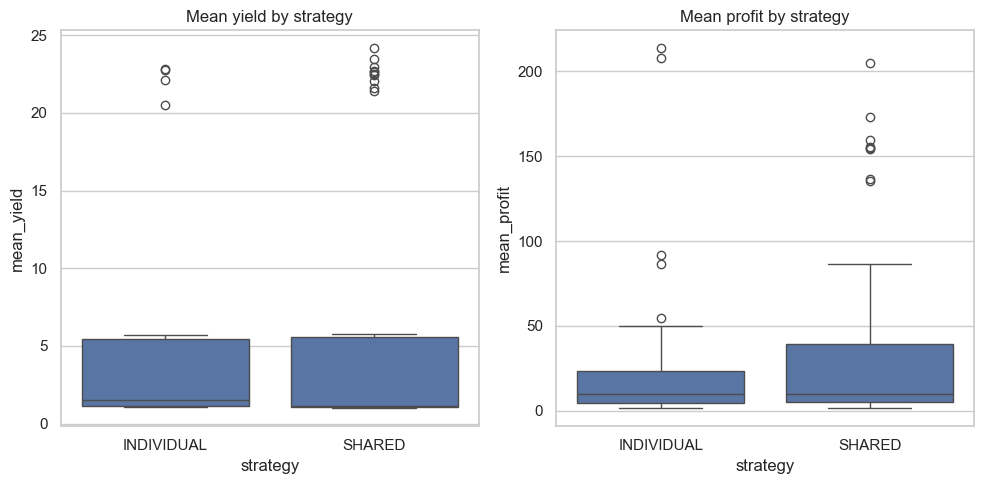

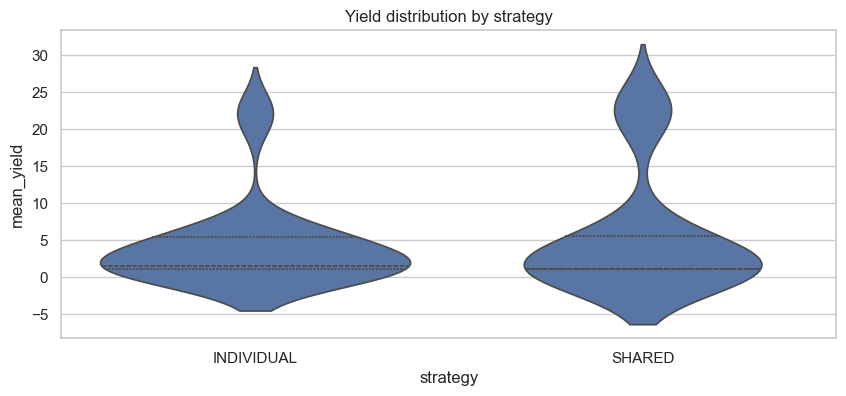

<Figure size 640x480 with 0 Axes>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
try:
    import seaborn as sns
    sns.set(style="whitegrid")
except Exception:
    sns = None

# Collect per-agent summary (mean yield and mean profit)
rows = []
agents = getattr(model, 'farmers', None) or getattr(model, 'agents', None) or []
for a in agents:
    mem = getattr(a, 'memory', [])
    if not mem:
        continue
    yields = [m['yield'] for m in mem if 'yield' in m]
    profits = [m['profit'] for m in mem if 'profit' in m]
    rows.append({
        'unique_id': getattr(a, 'unique_id', None),
        'strategy': getattr(a, 'strategy_type', None),
        'zone': getattr(getattr(a, 'zone', None), 'id', None),
        'mean_yield': sum(yields)/len(yields) if yields else None,
        'mean_profit': sum(profits)/len(profits) if profits else None,
        'yields': yields,
        'profits': profits,
    })

df = pd.DataFrame(rows)
display(df.groupby('strategy')[['mean_yield','mean_profit']].describe())

plt.figure(figsize=(10,5))
if sns is not None:
    plt.subplot(1,2,1)
    sns.boxplot(x='strategy', y='mean_yield', data=df)
    plt.title('Mean yield by strategy')
    plt.subplot(1,2,2)
    sns.boxplot(x='strategy', y='mean_profit', data=df)
    plt.title('Mean profit by strategy')
else:
    df.boxplot(column='mean_yield', by='strategy', rot=45, grid=False, figsize=(5,4))
    plt.title('Mean yield by strategy')
    plt.suptitle('')
    plt.show()

plt.tight_layout()
plt.show()

# Optional: violin for distribution if seaborn available
plt.figure(figsize=(10,4))
if sns is not None:
    sns.violinplot(x='strategy', y='mean_yield', data=df, inner='quartile')
    plt.title('Yield distribution by strategy')
    plt.show()

# Save summarized plot
plt.savefig('strategy_yield_profit_boxplots.png')

In [ ]:
import networkx as nx

# Create a graph
G = nx.Graph()

# Add nodes (farmers)
for agent in model.farmers:
    G.add_node(agent.unique_id, agent=agent)

# Connect nodes (edges represent communication or influence)
for agent in model.farmers:
    neighbors = random.sample(model.farmers, k=3)  # each farmer has 3 neighbors
    for neighbor in neighbors:
        if agent != neighbor:
            G.add_edge(agent.unique_id, neighbor.unique_id)
